## Interpretation

The baseline model provides:
- **Accuracy**: Overall correctness of predictions
- **Precision**: Of predicted "up" days, how many were actually up
- **Recall**: Of actual "up" days, how many did we catch
- **ROC-AUC**: Model's ability to discriminate between classes (0.5 = random, 1.0 = perfect)

For financial time series:
- Test set performance is most important (unseen future data)
- Precision/recall trade-off matters for trading strategy design
- ROC-AUC > 0.5 suggests some predictive signal beyond random chance

### Analysis and Recommendations

**Key observations:**

1. **Best validation performance**: Check which model has the highest ROC-AUC on validation set
2. **Test set generalization**: Compare validation vs test performance to assess robustness
3. **Overfitting indicators**: Large gaps between train and validation/test performance suggest overfitting
4. **Ensemble benefit**: Does the ensemble improve over individual models?

**For trading applications:**
- ROC-AUC is most important (captures ranking quality for position sizing)
- Precision matters for limiting false positive signals (bad trades)
- Recall matters for capturing profitable opportunities

**Next steps:**
- Consider feature importance analysis
- Tune decision threshold for precision/recall trade-off
- Implement walk-forward validation for production robustness

### Trading Performance Interpretation

**Key findings from test set trading simulation:**

1. **Best risk-adjusted performance**: Examine which strategy has the highest Sharpe ratio, balancing returns against volatility. Negative or near-zero Sharpe ratios indicate poor risk-adjusted returns.

2. **Drawdown comparison**: Models with smaller maximum drawdowns preserve capital better during adverse market conditions. Compare strategy drawdowns to buy-and-hold to assess downside protection.

3. **Cumulative returns**: While cumulative returns show total gain, they don't account for risk. A strategy with lower returns but higher Sharpe may be preferable for risk-adjusted performance.

4. **Overfitting evidence**: If a model showed strong validation performance but weak test trading metrics, this confirms overfitting - the model learned patterns that don't generalize to unseen data.

5. **Strategy limitations**: This simple long-only approach (predict up = buy, predict down = cash) ignores:
   - Transaction costs (can erode returns significantly with frequent trading)
   - Position sizing (binary in/out vs. scaled positions)
   - Short positions (can't profit from down predictions)
   - Market regime changes (models trained on bull markets may fail in bear markets)

**Practical implications**: For real trading, consider ensemble predictions, dynamic thresholds, position sizing based on prediction confidence, and robust walk-forward validation.

In [53]:
# Compute trading metrics for all strategies
strategies = {
    'Baseline LR': (strategy_ret_lr, eq_lr),
    'Random Forest': (strategy_ret_rf, eq_rf),
    'XGBoost': (strategy_ret_xgb, eq_xgb),
    'Buy & Hold': (benchmark_ret, eq_bh)
}

trading_metrics = []
for name, (returns, equity) in strategies.items():
    metrics = {
        'Strategy': name,
        'Cumulative Return': equity.iloc[-1] - 1,
        'Sharpe Ratio': compute_sharpe_ratio(returns),
        'Max Drawdown': compute_max_drawdown(equity)
    }
    trading_metrics.append(metrics)

trading_metrics_df = pd.DataFrame(trading_metrics).set_index('Strategy')

print("\n" + "="*70)
print("TRADING PERFORMANCE METRICS (Test Set)")
print("="*70)
print(trading_metrics_df.round(4))
print("="*70)
print("\nNote: Strategies are long-only with 0.5 probability threshold.")
print("No transaction costs or slippage included.")


TRADING PERFORMANCE METRICS (Test Set)
               Cumulative Return  Sharpe Ratio  Max Drawdown
Strategy                                                    
Baseline LR               0.4086        1.1116       -0.1970
Random Forest             0.1638        0.7399       -0.1466
XGBoost                   0.1659        0.6935       -0.0702
Buy & Hold                0.5295        1.2124       -0.1876

Note: Strategies are long-only with 0.5 probability threshold.
No transaction costs or slippage included.


In [76]:
# Save trading performance metrics to CSV
import os
os.makedirs('../results', exist_ok=True)
trading_metrics_df.to_csv('../results/trading_metrics.csv')
print("✓ Trading metrics saved to results/trading_metrics.csv")

✓ Trading metrics saved to results/trading_metrics.csv


### Trading metrics summary

✓ Equity curves saved to figures/equity_curves_test.png


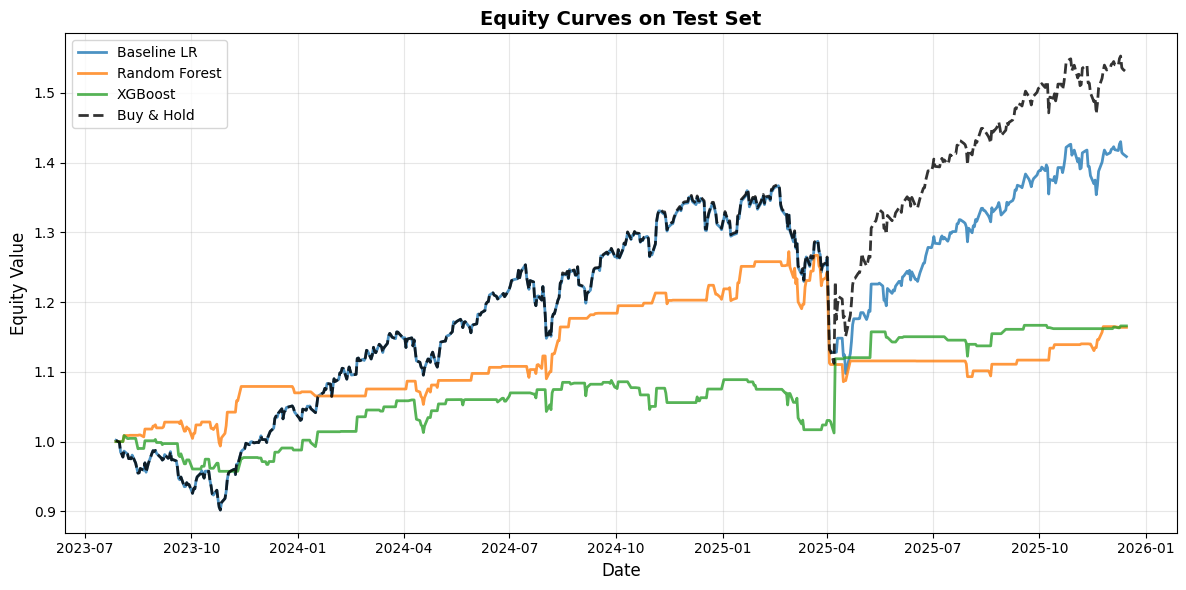

In [77]:
# Compute equity curves
eq_lr = compute_equity_curve(strategy_ret_lr)
eq_rf = compute_equity_curve(strategy_ret_rf)
eq_xgb = compute_equity_curve(strategy_ret_xgb)
eq_bh = compute_equity_curve(benchmark_ret)

# Plot equity curves
plt.figure(figsize=(12, 6))
plt.plot(eq_lr.index, eq_lr.values, label='Baseline LR', linewidth=2, alpha=0.8)
plt.plot(eq_rf.index, eq_rf.values, label='Random Forest', linewidth=2, alpha=0.8)
plt.plot(eq_xgb.index, eq_xgb.values, label='XGBoost', linewidth=2, alpha=0.8)
plt.plot(eq_bh.index, eq_bh.values, label='Buy & Hold', linewidth=2, alpha=0.8, linestyle='--', color='black')

plt.title('Equity Curves on Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Equity Value', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure before showing
import os
os.makedirs('../figures', exist_ok=True)
plt.savefig('../figures/equity_curves_test.png', dpi=300, bbox_inches='tight')
print("✓ Equity curves saved to figures/equity_curves_test.png")

plt.show()

### Equity curve visualization

In [55]:
# Extract future returns for test set
# Since future_ret_1d was dropped when creating X, we compute it from daily_ret
# The test set future return is the next day's return for each test observation
test_future_ret = X_test['daily_ret'].shift(-1)

# Note: The last observation will have NaN future return (unknown), so we drop it
test_future_ret = test_future_ret.dropna()

# Align X_test to match (drop last row)
X_test_aligned = X_test.loc[test_future_ret.index]
y_test_aligned = y_test.loc[test_future_ret.index]

# Compute strategy returns for each model
strategy_ret_lr = get_strategy_returns(model, X_test_aligned, test_future_ret)
strategy_ret_rf = get_strategy_returns(rf_best, X_test_aligned, test_future_ret)
strategy_ret_xgb = get_strategy_returns(xgb_best, X_test_aligned, test_future_ret)

# Benchmark: buy-and-hold (always long)
benchmark_ret = test_future_ret

print("Strategy returns computed for all models.")
print(f"Test period: {X_test_aligned.index.min().date()} to {X_test_aligned.index.max().date()}")
print(f"Number of test days: {len(X_test_aligned)}")

Strategy returns computed for all models.
Test period: 2023-07-28 to 2025-12-15
Number of test days: 599


### Compute strategy returns on test set

In [56]:
# Helper to convert classifier predictions to strategy returns
def get_strategy_returns(model, X, future_returns, threshold: float = 0.5) -> pd.Series:
    """
    Generate strategy returns from classifier predictions.
    
    Simple long-only strategy:
    - If P(up) >= threshold: hold long (return = future_return)
    - Otherwise: stay out (return = 0)
    
    Args:
        model: Trained classifier with predict_proba method
        X: Feature matrix
        future_returns: Next-period returns aligned with X
        threshold: Probability threshold for long signal
    
    Returns:
        Series of strategy returns aligned with X index
    """
    # Get predicted probabilities for positive class
    proba = model.predict_proba(X)[:, 1]
    
    # Generate signal: 1 if prob >= threshold, else 0
    signal = (proba >= threshold).astype(int)
    
    # Strategy returns: signal * actual return
    strategy_ret = signal * future_returns.values
    
    return pd.Series(strategy_ret, index=X.index, name='strategy_ret')


print("Strategy return function defined successfully.")

Strategy return function defined successfully.


In [57]:
# Utility functions for trading metrics
def compute_equity_curve(returns: pd.Series) -> pd.Series:
    """
    Compute cumulative equity curve from daily returns.
    
    Args:
        returns: Series of daily returns
    
    Returns:
        Series of cumulative equity (starting at 1.0)
    """
    return (1 + returns).cumprod()


def compute_sharpe_ratio(returns: pd.Series, trading_days: int = 252) -> float:
    """
    Compute annualized Sharpe ratio.
    
    Args:
        returns: Series of daily returns
        trading_days: Number of trading days per year for annualization
    
    Returns:
        Annualized Sharpe ratio
    """
    if returns.std() == 0:
        return 0.0
    return (returns.mean() / returns.std()) * np.sqrt(trading_days)


def compute_max_drawdown(equity_curve: pd.Series) -> float:
    """
    Compute maximum drawdown from equity curve.
    
    Args:
        equity_curve: Series of cumulative equity values
    
    Returns:
        Maximum drawdown as a negative percentage (e.g., -0.15 for 15% drawdown)
    """
    running_max = equity_curve.cummax()
    drawdown = equity_curve / running_max - 1
    return drawdown.min()


print("Trading utility functions defined successfully.")

Trading utility functions defined successfully.


## Trading Performance Evaluation

Convert model predictions into simple long-only trading strategies and evaluate with realistic metrics:
- Cumulative returns and equity curves
- Annualized Sharpe ratio
- Maximum drawdown

Compare against buy-and-hold benchmark on the test set.

In [58]:
# Consolidate all model results
all_models = {
    'Logistic Regression': results_df,
    'Random Forest': rf_results_df,
    'XGBoost': xgb_results_df,
    'RF+XGB Ensemble': ens_results_df
}

# Build comparison DataFrame
comparison_data = []
for model_name, df in all_models.items():
    row = {
        'Model': model_name,
        'Accuracy_train': df.loc['Train', 'Accuracy'],
        'ROC-AUC_train': df.loc['Train', 'ROC-AUC'],
        'Accuracy_val': df.loc['Validation', 'Accuracy'],
        'ROC-AUC_val': df.loc['Validation', 'ROC-AUC'],
        'Accuracy_test': df.loc['Test', 'Accuracy'],
        'ROC-AUC_test': df.loc['Test', 'ROC-AUC']
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data).set_index('Model')

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.round(4))
print("\n" + "="*80)


MODEL COMPARISON SUMMARY
                     Accuracy_train  ROC-AUC_train  Accuracy_val  ROC-AUC_val  Accuracy_test  ROC-AUC_test
Model                                                                                                     
Logistic Regression          0.5744         0.5505        0.5125       0.5057         0.5650        0.4897
Random Forest                0.6562         0.9089        0.5058       0.4956         0.4733        0.5099
XGBoost                      0.9850         0.9991        0.5008       0.5180         0.4267        0.4414
RF+XGB Ensemble              0.9617         0.9987        0.4925       0.5161         0.4250        0.4449



In [75]:
# Save model comparison metrics to CSV
import os
os.makedirs('../results', exist_ok=True)
comparison_df.to_csv('../results/model_metrics.csv')
print("✓ Model metrics saved to results/model_metrics.csv")

✓ Model metrics saved to results/model_metrics.csv


### Model comparison summary

Compare all models side-by-side to identify the best performer.

In [59]:
# Helper function for ensemble evaluation
def evaluate_ensemble(rf_model, xgb_model, X, y, set_name):
    """Evaluate ensemble by averaging RF and XGB probabilities."""
    # Get predicted probabilities for positive class
    p_rf = rf_model.predict_proba(X)[:, 1]
    p_xgb = xgb_model.predict_proba(X)[:, 1]
    
    # Average probabilities
    p_ens = 0.5 * (p_rf + p_xgb)
    
    # Convert to class predictions (threshold 0.5)
    y_pred = (p_ens > 0.5).astype(int)
    
    return {
        'Set': set_name,
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'ROC-AUC': roc_auc_score(y, p_ens)
    }

# Evaluate ensemble on all splits
ens_results = []
ens_results.append(evaluate_ensemble(rf_best, xgb_best, X_train, y_train, 'Train'))
ens_results.append(evaluate_ensemble(rf_best, xgb_best, X_val, y_val, 'Validation'))
ens_results.append(evaluate_ensemble(rf_best, xgb_best, X_test, y_test, 'Test'))

ens_results_df = pd.DataFrame(ens_results).set_index('Set')
print("\nRF + XGB Ensemble Results:")
print(ens_results_df.round(4))


RF + XGB Ensemble Results:
            Accuracy  Precision  Recall  ROC-AUC
Set                                             
Train         0.9617     0.9384  0.9968   0.9987
Validation    0.4925     0.5130  0.3204   0.5161
Test          0.4250     0.5000  0.1884   0.4449


### RF + XGB probability ensemble

Combine predictions from Random Forest and XGBoost by averaging their predicted probabilities.

In [60]:
# Evaluate XGBoost on all splits
xgb_results = []
xgb_results.append(evaluate_model(xgb_best, X_train, y_train, 'Train'))
xgb_results.append(evaluate_model(xgb_best, X_val, y_val, 'Validation'))
xgb_results.append(evaluate_model(xgb_best, X_test, y_test, 'Test'))

xgb_results_df = pd.DataFrame(xgb_results).set_index('Set')
print("\nXGBoost Results:")
print(xgb_results_df.round(4))


XGBoost Results:
            Accuracy  Precision  Recall  ROC-AUC
Set                                             
Train         0.9850     0.9791  0.9942   0.9991
Validation    0.5008     0.5253  0.3366   0.5180
Test          0.4267     0.5036  0.2029   0.4414


In [61]:
# XGBoost hyperparameter grid
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=300
)

xgb_param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# Tune XGBoost
print("Tuning XGBoost...")
xgb_best, xgb_cv_results = tune_model_time_series(xgb_model, xgb_param_grid, X_train, y_train, n_splits=3)

Tuning XGBoost...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best CV ROC-AUC: 0.5264


### XGBoost with time-series CV

In [62]:
# Evaluate Random Forest on all splits
rf_results = []
rf_results.append(evaluate_model(rf_best, X_train, y_train, 'Train'))
rf_results.append(evaluate_model(rf_best, X_val, y_val, 'Validation'))
rf_results.append(evaluate_model(rf_best, X_test, y_test, 'Test'))

rf_results_df = pd.DataFrame(rf_results).set_index('Set')
print("\nRandom Forest Results:")
print(rf_results_df.round(4))


Random Forest Results:
            Accuracy  Precision  Recall  ROC-AUC
Set                                             
Train         0.6562     0.6186  0.9994   0.9089
Validation    0.5058     0.5300  0.3722   0.4956
Test          0.4733     0.6028  0.2464   0.5099


In [63]:
# Random Forest hyperparameter grid
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [4, 6, 8],
    'max_features': ['sqrt', 0.5]
}

# Tune Random Forest
print("Tuning Random Forest...")
rf_best, rf_cv_results = tune_model_time_series(rf_model, rf_param_grid, X_train, y_train, n_splits=3)

Tuning Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 400}
Best CV ROC-AUC: 0.5108


### Random Forest with time-series CV

In [64]:
# Helper function for time-series cross-validation grid search
def tune_model_time_series(model, param_grid, X_train, y_train, n_splits=3):
    """
    Tune a model using time-series cross-validation.
    
    Args:
        model: sklearn estimator or pipeline
        param_grid: dict of hyperparameters to search
        X_train: training features
        y_train: training labels
        n_splits: number of time-series splits
    
    Returns:
        best_estimator: fitted model with best parameters
        cv_results_df: DataFrame with cross-validation results
    """
    # Use time-series split (respects temporal order)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Grid search with ROC-AUC scoring
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tscv,
        scoring='roc_auc',
        refit=True,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Extract results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results_summary = cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].copy()
    cv_results_summary = cv_results_summary.sort_values('rank_test_score')
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_, cv_results_summary

In [65]:
# Additional imports for ensemble models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

## Ensemble Models with Time-Series Cross-Validation

Now we'll train more sophisticated ensemble models and compare them to the baseline.

In [66]:
# Evaluate on all splits
def evaluate_model(model, X, y, set_name):
    """Compute classification metrics for a given dataset."""
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    return {
        'Set': set_name,
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'ROC-AUC': roc_auc_score(y, y_pred_proba)
    }

# Compute metrics
results = []
results.append(evaluate_model(model, X_train, y_train, 'Train'))
results.append(evaluate_model(model, X_val, y_val, 'Validation'))
results.append(evaluate_model(model, X_test, y_test, 'Test'))

# Display results
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Set')
print("\nBaseline Logistic Regression Results:")
print(results_df.round(4))


Baseline Logistic Regression Results:
            Accuracy  Precision  Recall  ROC-AUC
Set                                             
Train         0.5746     0.5719  0.9422   0.5509
Validation    0.5109     0.5145  0.9159   0.5040
Test          0.5650     0.5719  0.9681   0.4879


In [67]:
# Create pipeline with standardization and logistic regression
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train model
print("Training logistic regression...")
model.fit(X_train, y_train)
print("Training complete!")

Training logistic regression...
Training complete!


## Baseline logistic regression model

Train a simple logistic regression with standardized features as a baseline.
This establishes minimum expected performance for more complex models.

In [68]:
# Calculate split indices
n = len(X)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

# Create chronological splits
X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

# Print split information
print("Split Summary:")
print(f"{'Set':<12} {'Size':<8} {'Start Date':<15} {'End Date':<15}")
print("-" * 55)
print(f"{'Train':<12} {len(X_train):<8} {X_train.index.min().strftime('%Y-%m-%d'):<15} {X_train.index.max().strftime('%Y-%m-%d'):<15}")
print(f"{'Validation':<12} {len(X_val):<8} {X_val.index.min().strftime('%Y-%m-%d'):<15} {X_val.index.max().strftime('%Y-%m-%d'):<15}")
print(f"{'Test':<12} {len(X_test):<8} {X_test.index.min().strftime('%Y-%m-%d'):<15} {X_test.index.max().strftime('%Y-%m-%d'):<15}")

Split Summary:
Set          Size     Start Date      End Date       
-------------------------------------------------------
Train        2796     2010-02-02      2021-03-11     
Validation   599      2021-03-12      2023-07-28     
Test         600      2023-07-31      2025-12-17     


## Time-based train/validation/test split

**Critical for time series**: Use chronological split, never shuffle.
- **Train**: First 70% of observations
- **Validation**: Next 15% of observations
- **Test**: Final 15% of observations

In [69]:
# Create future return for next day
df_features['future_ret_1d'] = df_features['daily_ret'].shift(-1)

# Create binary target: 1 if future return is positive, 0 otherwise
df_features['target_up'] = (df_features['future_ret_1d'] > 0).astype(int)

# Drop rows with NaN in target (last row due to shift)
df_features = df_features.dropna(subset=['future_ret_1d'])

# Separate features and target
X = df_features.drop(columns=['target_up', 'future_ret_1d'])
y = df_features['target_up']

print(f"Feature matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")
print(f"\nTarget distribution:\n{y.value_counts()}")
print(f"\nTarget proportion (up days): {y.mean():.2%}")

Feature matrix X shape: (3995, 26)
Target vector y shape: (3995,)

Target distribution:
target_up
1    2213
0    1782
Name: count, dtype: int64

Target proportion (up days): 55.39%


## Define label and supervised dataset

For directional prediction, we create a binary classification target:
- **Predict**: Will the price go up tomorrow?
- **Label**: `target_up = 1` if next-day return > 0, else 0
- **Features**: All technical indicators (excluding the target itself)

In [70]:
# View all feature column names
print("Feature columns:")
print(df_features.columns.tolist())

Feature columns:
['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'daily_ret', 'ret_lag_1', 'ret_lag_2', 'ret_lag_5', 'ret_lag_10', 'ret_roll_mean_5', 'ret_roll_std_5', 'ret_roll_mean_10', 'ret_roll_std_10', 'ret_roll_mean_20', 'ret_roll_std_20', 'ma_5', 'price_roll_std_5', 'bb_upper_5', 'bb_lower_5', 'ma_20', 'price_roll_std_20', 'bb_upper_20', 'bb_lower_20', 'rsi_14', 'future_ret_1d', 'target_up']


In [71]:
# Build feature matrix with technical indicators
df_features = build_feature_matrix(df_raw.copy())

print(f"Feature matrix shape: {df_features.shape}")
print(f"Number of features: {len(df_features.columns)}")
print(f"Date range after dropping NaNs: {df_features.index.min()} to {df_features.index.max()}")
df_features.head()

Feature matrix shape: (3996, 26)
Number of features: 26
Date range after dropping NaNs: 2010-02-02 00:00:00 to 2025-12-18 00:00:00


,Adj Close,Close,High,Low,Open,Volume,daily_ret,ret_lag_1,ret_lag_2,ret_lag_5,ret_lag_10,ret_roll_mean_5,ret_roll_std_5,ret_roll_mean_10,ret_roll_std_10,ret_roll_mean_20,ret_roll_std_20,ma_5,price_roll_std_5,bb_upper_5,bb_lower_5,ma_20,price_roll_std_20,bb_upper_20,bb_lower_20,rsi_14
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-02,83.059364,110.379997,110.589996,108.879997,109.260002,216327900,0.012103,0.015551,-0.010868,-0.004191,0.012495,0.002014,0.012653,-0.004068,0.012949,-0.001264,0.010585,82.055540,0.871331,83.798202,80.312879,84.348001,1.946778,88.241558,80.454444,48.244280
2010-02-03,82.645470,109.830002,110.480003,109.510002,109.879997,172730700,-0.004983,0.012103,0.015551,0.004757,-0.010168,0.000066,0.012873,-0.003550,0.012780,-0.001646,0.010574,82.055540,0.871331,83.798202,80.312879,84.205027,1.962279,88.129585,80.280469,46.098759
2010-02-04,80.094582,106.440002,109.029999,106.419998,108.980003,356715700,-0.030865,-0.004983,0.012103,-0.011472,-0.019229,-0.003813,0.018783,-0.004713,0.014745,-0.003224,0.012403,81.734985,1.249015,84.233016,79.236955,83.931499,2.136275,88.204049,79.658949,35.592805
2010-02-05,80.260132,106.660004,106.879997,104.580002,106.559998,493585800,0.002067,-0.030865,-0.004983,-0.010868,-0.022292,-0.001225,0.018457,-0.002277,0.013476,-0.003332,0.012344,81.625125,1.369156,84.363438,78.886813,83.648186,2.231400,88.110987,79.185386,36.602617
2010-02-08,79.680710,105.889999,107.330002,105.809998,106.739998,224166900,-0.007219,0.002067,-0.030865,0.015551,0.005127,-0.005779,0.015917,-0.003512,0.013287,-0.003860,0.012270,81.148051,1.576917,84.301886,77.994217,83.321606,2.312857,87.947320,78.695893,34.560254


## Build technical feature matrix

We use the `build_feature_matrix` function which adds:
- **Lagged returns** (1, 2, 5, 10 days) - momentum/reversal signals
- **Rolling statistics** (mean and std over 5, 10, 20 days) - trend and volatility
- **Moving averages** (5, 20 days) - price trend indicators
- **Bollinger Bands** (5, 20 days) - volatility bands for overbought/oversold
- **RSI** (14 days) - momentum oscillator

The function also drops rows with NaNs from initial rolling windows.

In [72]:
# Sanity check: view tail with price and returns
df_raw[['Adj Close', 'daily_ret']].tail()

,Adj Close,daily_ret
Date,,
2025-12-12,681.760010,-0.010752
2025-12-15,680.729980,-0.001511
2025-12-16,678.869995,-0.002732
2025-12-17,671.400024,-0.011004
2025-12-18,676.469971,0.007551


In [73]:
# Load raw data (skip header row with ticker symbols)
df_raw = pd.read_csv('../data/raw/SPY_daily.csv', skiprows=[1])

# Rename columns properly (first column is index/date, then Adj Close, Close, High, Low, Open, Volume)
df_raw.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Convert numeric columns to float
for col in ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')

# Parse date and set as index
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df_raw = df_raw.set_index('Date').sort_index()

# Compute daily returns (self-contained)
df_raw['daily_ret'] = df_raw['Adj Close'].pct_change()

print(f"Data shape: {df_raw.shape}")
print(f"Date range: {df_raw.index.min()} to {df_raw.index.max()}")
df_raw.head()

Data shape: (4016, 7)
Date range: 2010-01-04 00:00:00 to 2025-12-18 00:00:00


,Adj Close,Close,High,Low,Open,Volume,daily_ret
Date,,,,,,,
2010-01-04,85.279205,113.330002,113.389999,111.510002,112.370003,118944600,NaN
2010-01-05,85.504951,113.629997,113.680000,112.849998,113.260002,111579900,0.002647
2010-01-06,85.565140,113.709999,113.989998,113.430000,113.519997,116074400,0.000704
2010-01-07,85.926384,114.190002,114.330002,113.180000,113.500000,131091100,0.004222
2010-01-08,86.212311,114.570000,114.620003,113.660004,113.889999,126402800,0.003328


In [74]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Import feature engineering function
import sys
sys.path.append('..')
from src.features.technical import build_feature_matrix

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

## Load data and recompute returns

# Feature Engineering and Modeling for Financial Time Series

This notebook implements the full modeling pipeline:
1. Load and prepare SPY daily data
2. Build technical features using `src.features.technical`
3. Define prediction target (next-day direction)
4. Create time-based train/validation/test splits
5. Train and evaluate baseline models